In [ ]:
# This was a dirty data set tha

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df=pd.read_csv('retail_store_sales.csv')

In [4]:
df.head(5)

,Transaction ID,Customer ID,Category,Item,Price Per Unit,Quantity,Total Spent,Payment Method,Location,Transaction Date,Discount Applied
0,TXN_6867343,CUST_09,Patisserie,Item_10_PAT,18.5,10.0,185.0,Digital Wallet,Online,2024-04-08,True
1,TXN_3731986,CUST_22,Milk Products,Item_17_MILK,29.0,9.0,261.0,Digital Wallet,Online,2023-07-23,True
2,TXN_9303719,CUST_02,Butchers,Item_12_BUT,21.5,2.0,43.0,Credit Card,Online,2022-10-05,False
3,TXN_9458126,CUST_06,Beverages,Item_16_BEV,27.5,9.0,247.5,Credit Card,Online,2022-05-07,NaN
4,TXN_4575373,CUST_05,Food,Item_6_FOOD,12.5,7.0,87.5,Digital Wallet,Online,2022-10-02,False


In [5]:
df.isnull().sum()

Transaction ID         0
Customer ID            0
Category               0
Item                1213
Price Per Unit       609
Quantity             604
Total Spent          604
Payment Method         0
Location               0
Transaction Date       0
Discount Applied    4199
dtype: int64

In [6]:
df['Price Per Unit']=df['Price Per Unit'].fillna(df['Total Spent']/df['Quantity'])

In [7]:
df['Item'] = df.groupby(['Price Per Unit', 'Category'])['Item'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

C:\Users\soura\AppData\Local\Temp\ipykernel_6452\1897176963.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Item'] = df.groupby(['Price Per Unit', 'Category'])['Item'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [8]:
df['Transaction Date']=pd.to_datetime(df['Transaction Date'])

In [9]:
df['Quantity']=df['Quantity'].fillna(df.groupby('Item')['Quantity'].transform('mean'))

In [10]:
df['Total Spent']=df['Total Spent'].fillna(df['Price Per Unit']*df['Quantity'])

In [11]:
# Calculate the discount rate per item (percentage of times it was True)
item_discount_rate = df.groupby('Item')['Discount Applied'].mean()

# Fill missing values: If an item usually gets a discount (more than 50% of the time), set to True; otherwise, False
df['Discount Applied'] = df.apply(
    lambda row: True if pd.isna(row['Discount Applied']) and item_discount_rate[row['Item']] > 0.5
    else (False if pd.isna(row['Discount Applied']) else row['Discount Applied']), axis=1
)

In [19]:
df.isnull().sum()

Transaction_ID      0
Customer_ID         0
Category            0
Item                0
Price_Per_Unit      0
Quantity            0
Total_Spent         0
Payment_Method      0
Location            0
Transaction_Date    0
Discount_Applied    0
dtype: int64

<Axes: xlabel='Category'>

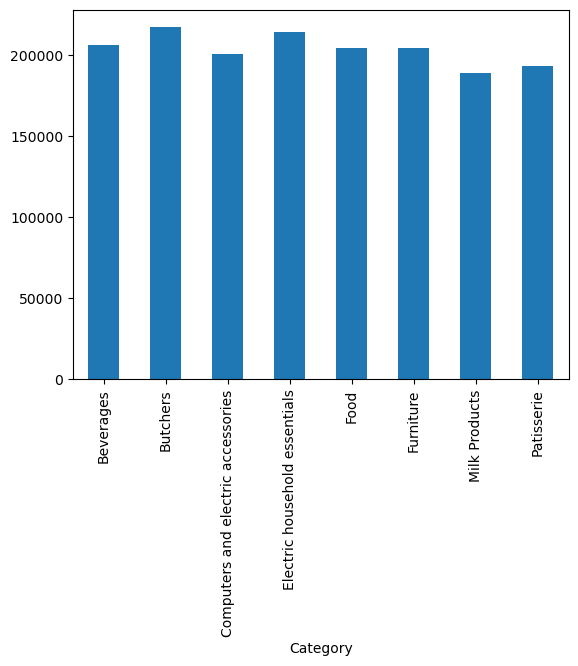

In [13]:
df.groupby('Category')['Total Spent'].sum().plot(kind='bar')

In [18]:
df.columns = df.columns.str.replace(' ', '_')

In [21]:
df.Customer_ID.nunique()

25

In [17]:
df.groupby('Category')['Total Spent'].sum()

Category
Beverages                             206416.187805
Butchers                              217301.036759
Computers and electric accessories    201171.294314
Electric household essentials         214411.390616
Food                                  204553.862251
Furniture                             204544.022790
Milk Products                         189112.583034
Patisserie                            193370.769228
Name: Total Spent, dtype: float64

In [22]:
df.Total_Spent.mean()

129.69233771753977

In [23]:
df.Payment_Method.value_counts()

Payment_Method
Cash              4310
Digital Wallet    4144
Credit Card       4121
Name: count, dtype: int64

In [24]:
df.groupby('Location')['Total_Spent'].sum()

Location
In-store    802004.125738
Online      828877.021060
Name: Total_Spent, dtype: float64

<Axes: xlabel='Transaction_Date'>

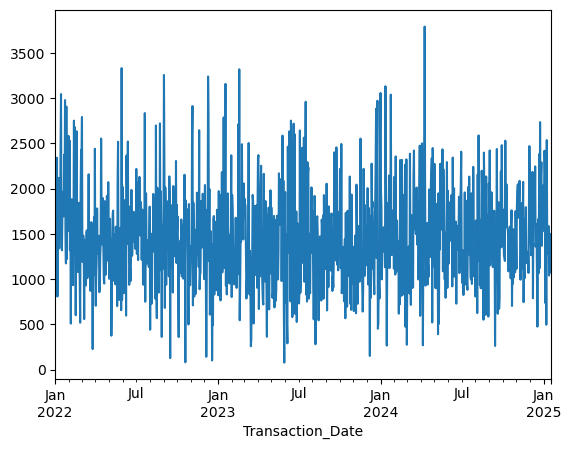

In [27]:
df.groupby('Transaction_Date')['Total_Spent'].sum().plot(kind='line')

In [31]:
# Extract the day of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
df['Day of Week'] = df['Transaction_Date'].dt.day_name()

# Group by 'Day of Week' and sum 'Total Spent'
sales_by_day = df.groupby('Day of Week')['Total_Spent'].sum()

# Find the day with the highest sales
highest_sales_day = sales_by_day.idxmax()

In [33]:
highest_sales_day

'Friday'

In [40]:
# Select only numerical columns
numerical_data = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_matrix = numerical_data.corr()

# Display the correlation matrix
print(corr_matrix)

                Price_Per_Unit  Quantity  Total_Spent
Price_Per_Unit        1.000000  0.010577     0.639948
Quantity              0.010577  1.000000     0.705327
Total_Spent           0.639948  0.705327     1.000000


In [43]:
# 1. Filter the customers who got a discount (Discount Applied = True)
discount_customers = df[df['Discount_Applied'] == True]

# 2. Identify customers who made subsequent purchases
# 3. Sort the DataFrame by 'Customer ID' and 'Transaction Date'
df_sorted = df.sort_values(by=['Customer_ID', 'Transaction_Date'])

# 4. Check if these customers returned for another purchase
df_sorted['Returned After Discount'] = df_sorted.groupby('Customer_ID')['Transaction_Date'].shift(-1) > df_sorted['Transaction_Date']

# 5. Filter out customers who had a discount and returned
returned_customers = df_sorted[(df_sorted['Discount_Applied'] == True) & (df_sorted['Returned After Discount'] == True)]

# Display the customers who got a discount and returned
print(returned_customers)

      Transaction_ID Customer_ID                            Category  \
3327     TXN_6950467     CUST_01  Computers and electric accessories   
3065     TXN_9662767     CUST_01                           Beverages   
9001     TXN_9753172     CUST_01  Computers and electric accessories   
10293    TXN_1701594     CUST_01                       Milk Products   
1950     TXN_1860120     CUST_01                           Furniture   
...              ...         ...                                 ...   
10406    TXN_7872818     CUST_25                          Patisserie   
2642     TXN_7256566     CUST_25                          Patisserie   
960      TXN_9196494     CUST_25       Electric household essentials   
8566     TXN_6314774     CUST_25                       Milk Products   
7772     TXN_4454614     CUST_25                          Patisserie   

               Item  Price_Per_Unit  Quantity  Total_Spent  Payment_Method  \
3327     Item_6_CEA            12.5       6.0         75.